### Group Members: Weston Lu, Kevin Wang, Aamir Mohsin
# Data Science Lab: Lab 3

Submit:
1. A pdf of your notebook with solutions. Make sure that the solutions are present and visible in the pdf.
2. A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Lab

1. More experience with regression and ridge regression (regularization)
2. Start playing with Kaggle
3. More experience with Lasso.
4. An initial shot at ensembling and stacking.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


C:\Users\aamir\AppData\Local\Temp\ipykernel_32680\146195214.py:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


## Problem 1 (Optional)

**Part 1** Make sure you can run through and understand the Jupyter notebook on Ridge
Regression and Colinearity we saw in class: https://colab.research.google.com/drive/1R7xTNHxAwhL1tANiGT2KRO-OT0D8KV2Z

**Part 2.** What is the test error of the “zero-variance” solution, namely, the all-zeros solution?

**Part 3.** The least-squares solution does not seem to do too well, because it has so much variance. Still, it is unbiased. Show this empirically: generate many copies of the data, and for each one, obtain the least-squares solution. Average these, to show that while each run produces a beta hat that is very different, their average begins to look more and more like the true beta.

**Part 4.** Alternatively, if one had access to lots of data, instead of computing the least-square solution over smaller batches and then averaging these solutions as in the previous part of the problem, an approach is to run a single least-squares regression over all the data. Which approach do you think is better? Can you support your conclusion with experiments?


### Problem 2: Starting in Kaggle.
Later this semester, we are opening a Kaggle competition made for this class. In that one, you will be participating on your own. This is an intro to get us started, and also an excuse to work with regularization and regression which we have been discussing.

**Part 1.** Let’s start with our first Kaggle submission in a playground regression competition. Make an account to Kaggle and find https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

**Part 2.** Follow the data preprocessing steps from (new link!) https://www.kaggle.com/code/apapiu/regularized-linear-models. Then run a ridge regression using $\lambda = 0.1$. Make a submission of this prediction, what is the RMSE you get? (Hint: remember to exponentiate np.expm1(ypred) your predictions).



**Part 3.** Compare a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

**Part 4.** The $\ell_0$ (or $L_0$) norm is the number of nonzeros of a vector. Plot the $L_0$ norm of the coefficients that lasso produces as you vary the strength of regularization parameter $\lambda$.

**Part 5.** Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit. What score can you get? (We will be discussing ensembling more, later in the class, but you can start playing with it now).

## Part 1

In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price + 1)'}>]], dtype=object)

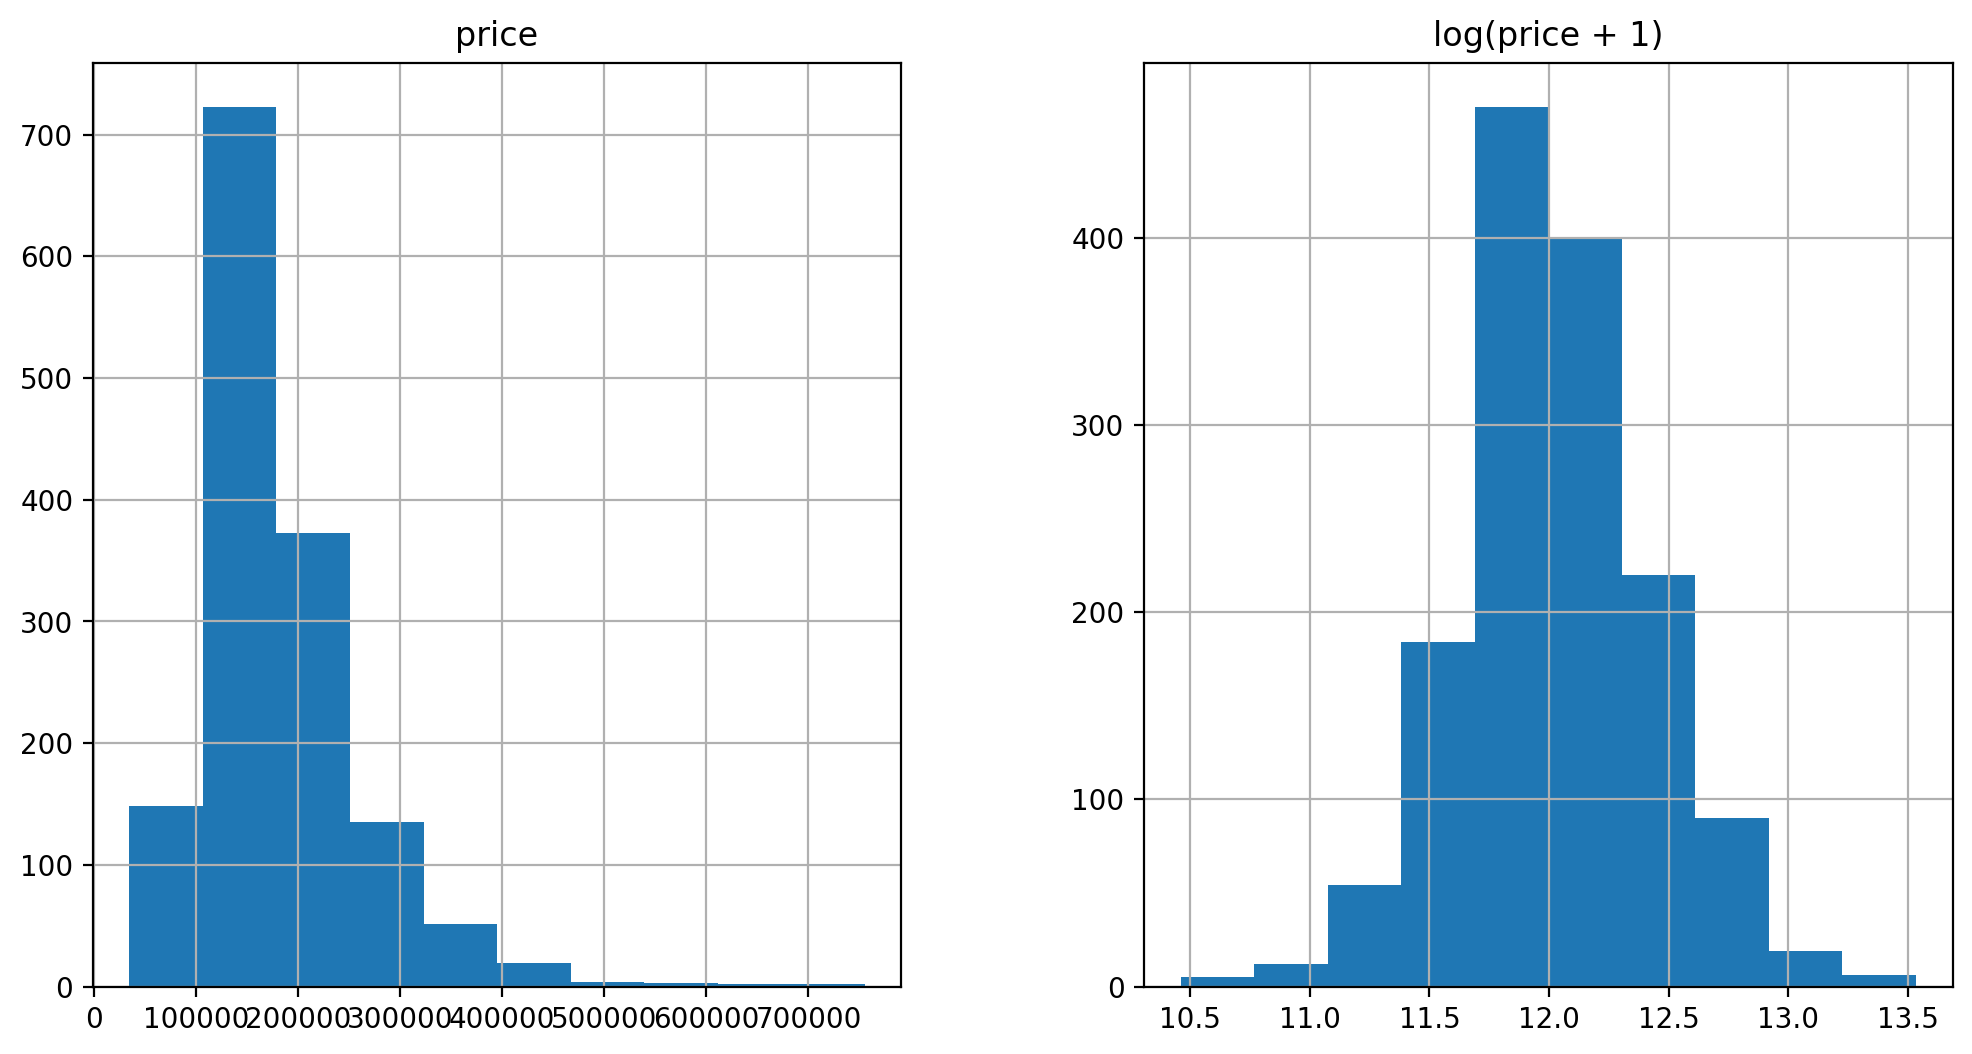

In [8]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [9]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [10]:
all_data = pd.get_dummies(all_data)

In [11]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [12]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Part 2

In [14]:
my_ridge = Ridge(alpha=0.1)

In [15]:
my_ridge.fit(X_train, y)
y_pred = my_ridge.predict(X_test)

y_pred = np.expm1(y_pred)

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': y_pred})
submission.to_csv('ECE460J-submission.csv', index=False)

In [16]:
rmse = rmse_cv(my_ridge).mean()
print(f'Calculated RMSE: {rmse}')

Calculated RMSE: 0.13774989813145017


## Part 3

In [17]:
model_lasso = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5).fit(X_train, y)

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36905416807673497, tolerance: 0.018002191385488822
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19724539365795835, tolerance: 0.018373605848561597
  model = cd_fast.enet_coordinate_descent_gram(


In [18]:
optimal_alpha = model_lasso.alpha_
print(f'Calculated Optimal Alpha (Lasso): {optimal_alpha}')

Calculated Optimal Alpha (Lasso): 0.0005428675439323859


In [19]:
y_pred = model_lasso.predict(X_test)

rmse = rmse_cv(model_lasso).mean()

print(f'Calculated RMSE: {rmse}')

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20741714203493444, tolerance: 0.014608206095799353
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1742083384859816, tolerance: 0.015531757542978093
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43422491456169876, tolerance: 0.015453647710308879
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did no

Calculated RMSE: 0.12306433395149752


In [20]:
optimal_ridge = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=5)

In [21]:
optimal_ridge.fit(X_train, y)

RidgeCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
       3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
       9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
       2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
       8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
       2.65608778e-04, 3.51119173e-0...
       1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
       4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
       1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
       4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
       1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
       4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
        cv=5)

In [22]:
optimal_alpha_ridge = optimal_ridge.alpha_
print(f'Calculated Optimal Alpha (Ridge): {optimal_alpha_ridge}')

Calculated Optimal Alpha (Ridge): 10.722672220103231


In [24]:
rmse_ridge = rmse_cv(optimal_ridge).mean()

print(f'Calculated RMSE (Ridge): {rmse_ridge}')
print(f'Calculated RMSE (Lasso): {rmse}')

Calculated RMSE (Ridge): 0.12734878989113932
Calculated RMSE (Lasso): 0.12306433395149752


## Part 4

In [25]:
from sklearn.linear_model import Lasso

lambdas = np.logspace(-4, 1, 50)

L0_quantities = []

for l in lambdas:
    lasso = Lasso(alpha=l)
    lasso.fit(X_train, y)

    coef = lasso.coef_

    L0_norm = np.sum(coef != 0)
    L0_quantities.append(L0_norm)

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.246e-01, tolerance: 2.328e-02
  model = cd_fast.enet_coordinate_descent(


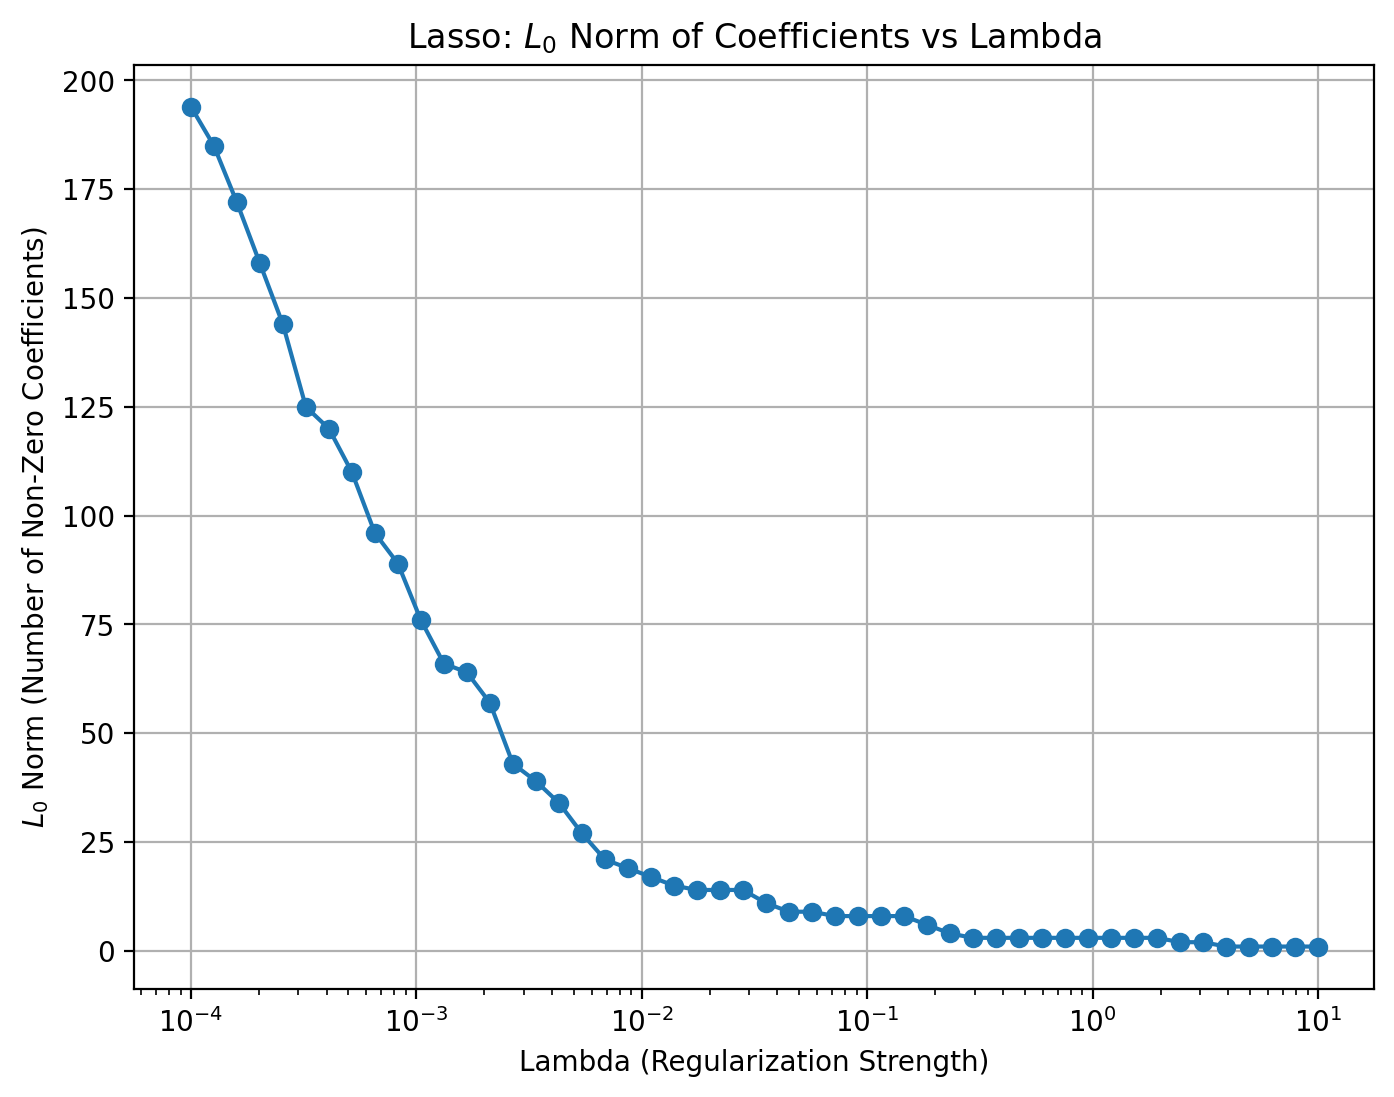

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(lambdas, L0_quantities, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('$L_0$ Norm (Number of Non-Zero Coefficients)')
plt.title('Lasso: $L_0$ Norm of Coefficients vs Lambda')
plt.grid(True)
plt.show()

## Part 5

In [27]:
O_ridge_pred = optimal_ridge.predict(X_train)
O_lasso_pred = model_lasso.predict(X_train)

X_train_stack = np.column_stack((X_train, O_ridge_pred, O_lasso_pred))

In [28]:
stacked_ridge = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=5)

stacked_ridge.fit(X_train_stack, y)

O_ridge_pred_test = optimal_ridge.predict(X_test)
O_lasso_pred_test = model_lasso.predict(X_test)

X_test_stack = np.column_stack((X_test, O_ridge_pred_test, O_lasso_pred_test))

final_pred = stacked_ridge.predict(X_test_stack)

final_rmse = rmse_cv(stacked_ridge).mean()

print(f'Calculated RMSE (Ensembled and Stacked): {final_rmse}')

Calculated RMSE (Ensembled and Stacked): 0.12734878989113932


## END OF PROBLEM 2

In [29]:
model_ridge = Ridge()

In [30]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

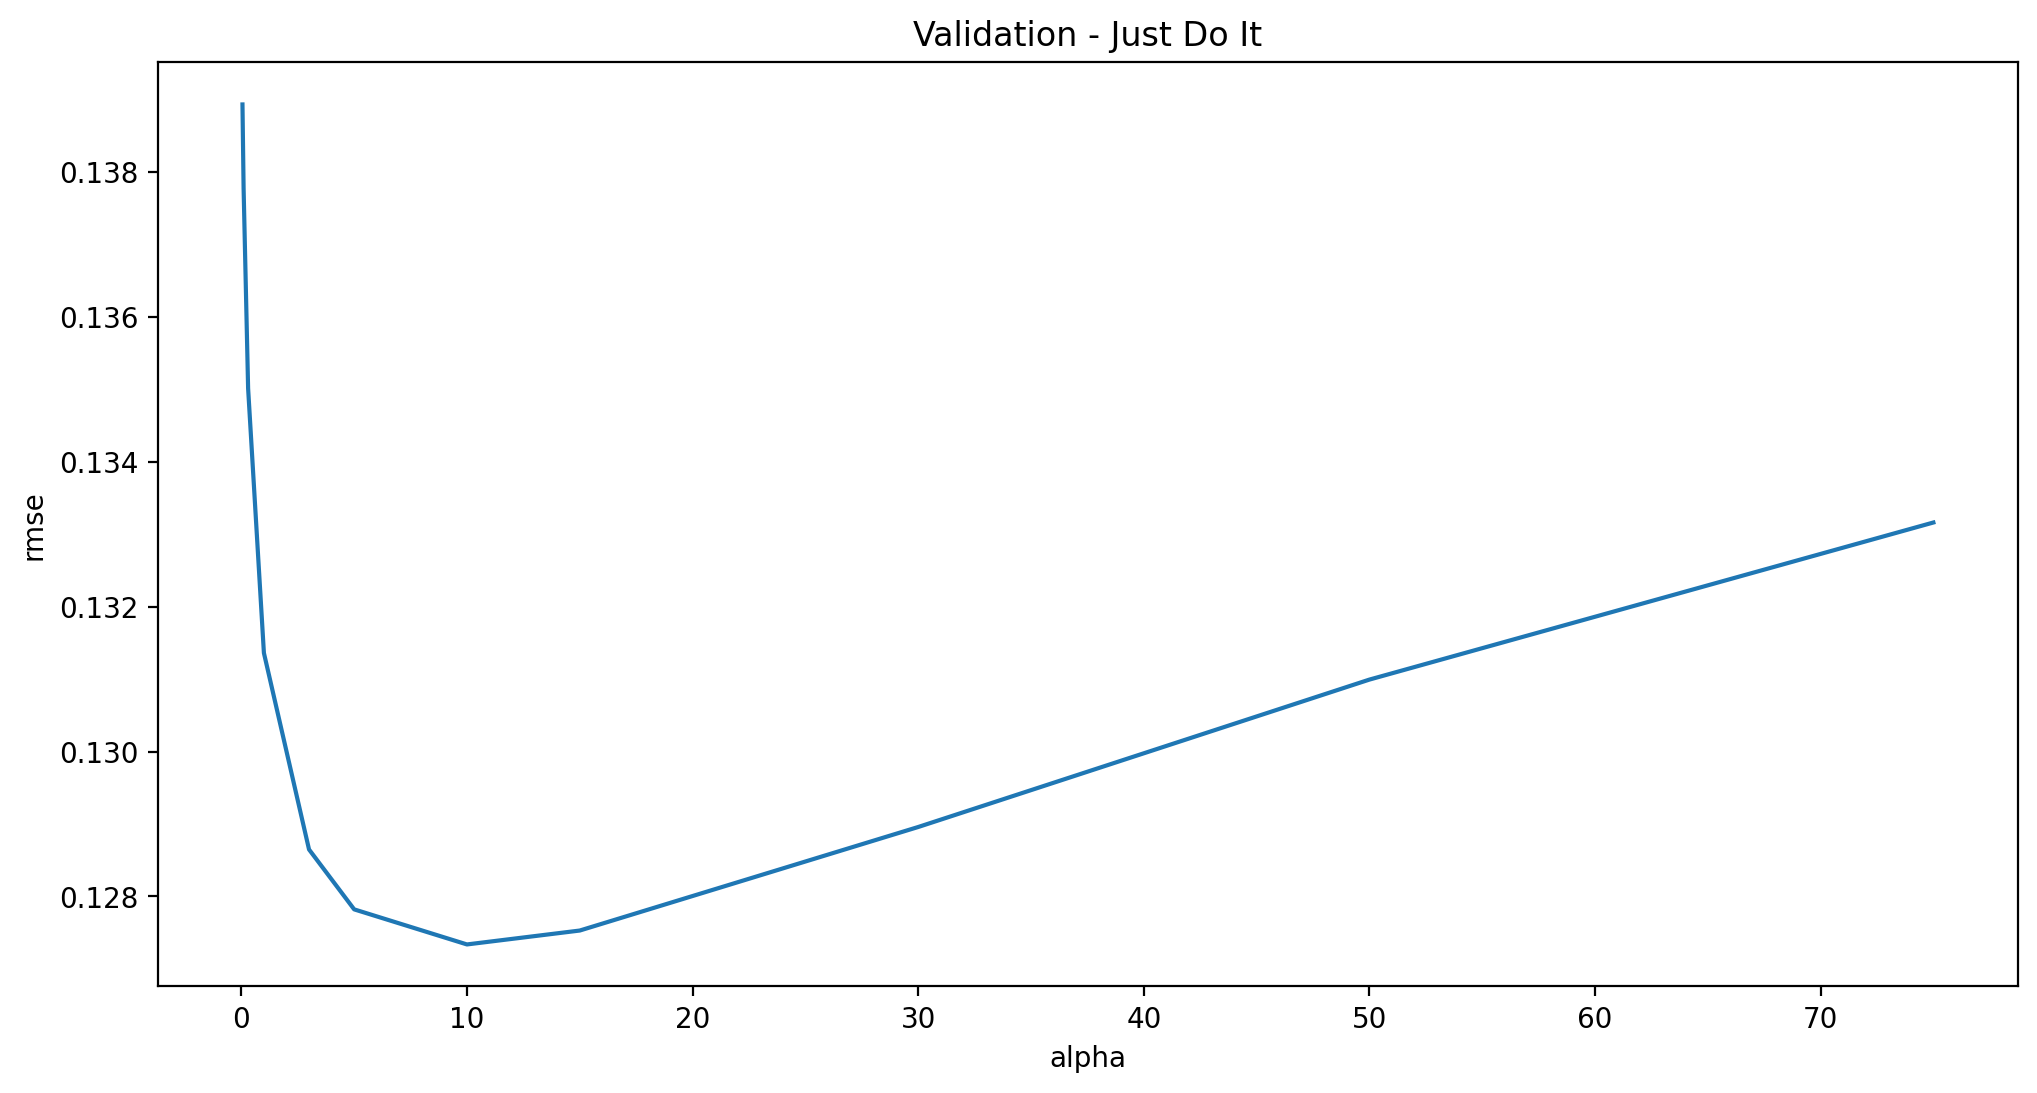

In [28]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [29]:
cv_ridge.min()

0.12733734668670776

In [30]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [31]:
rmse_cv(model_lasso).mean()

0.12256735885048128

In [32]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [33]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [34]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

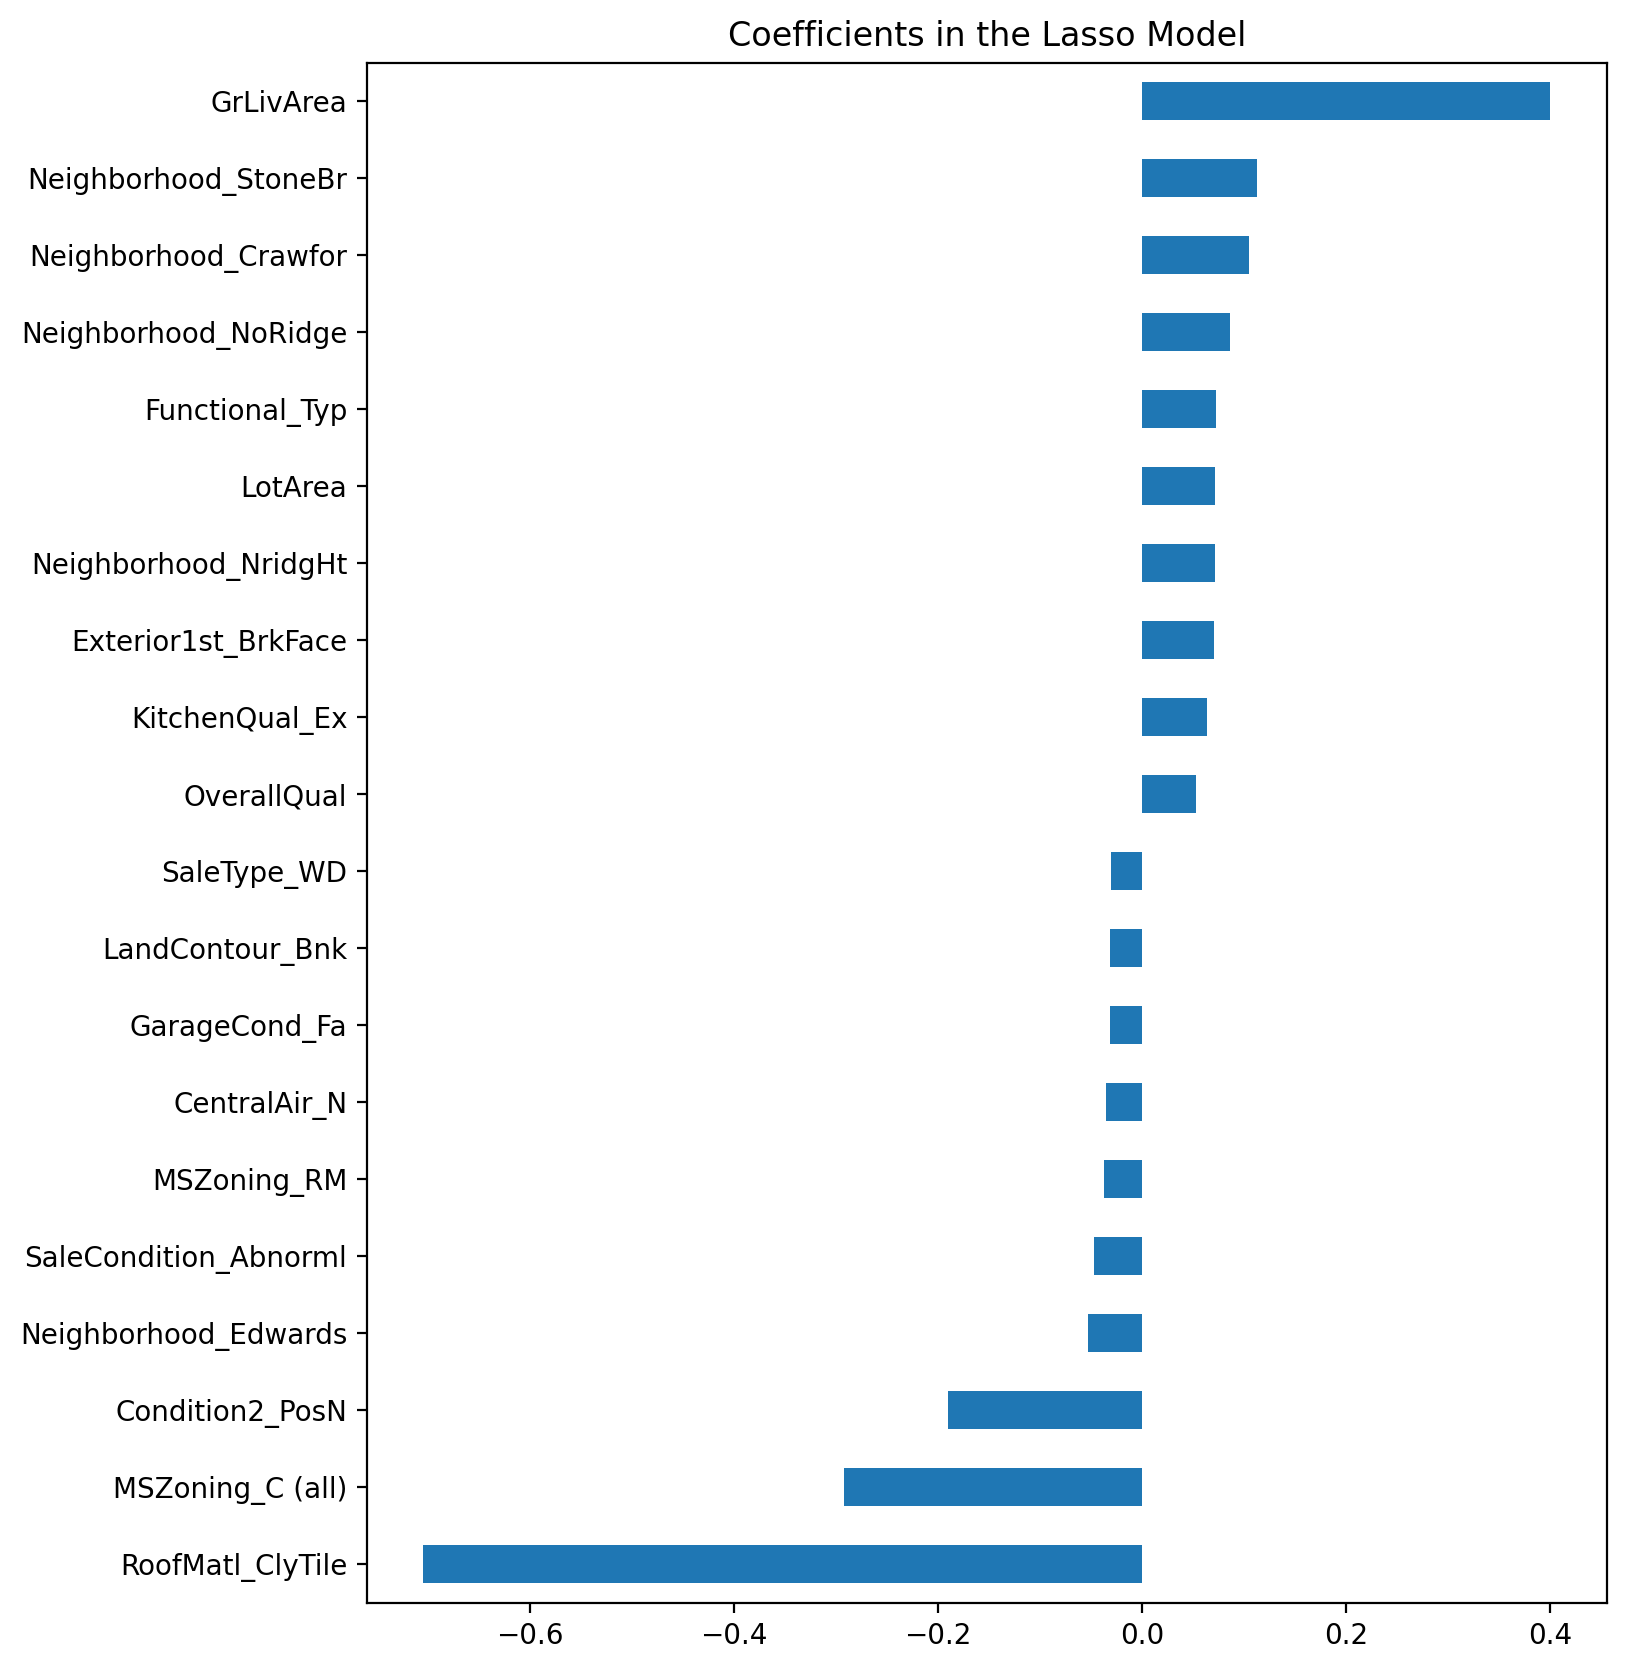

In [35]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

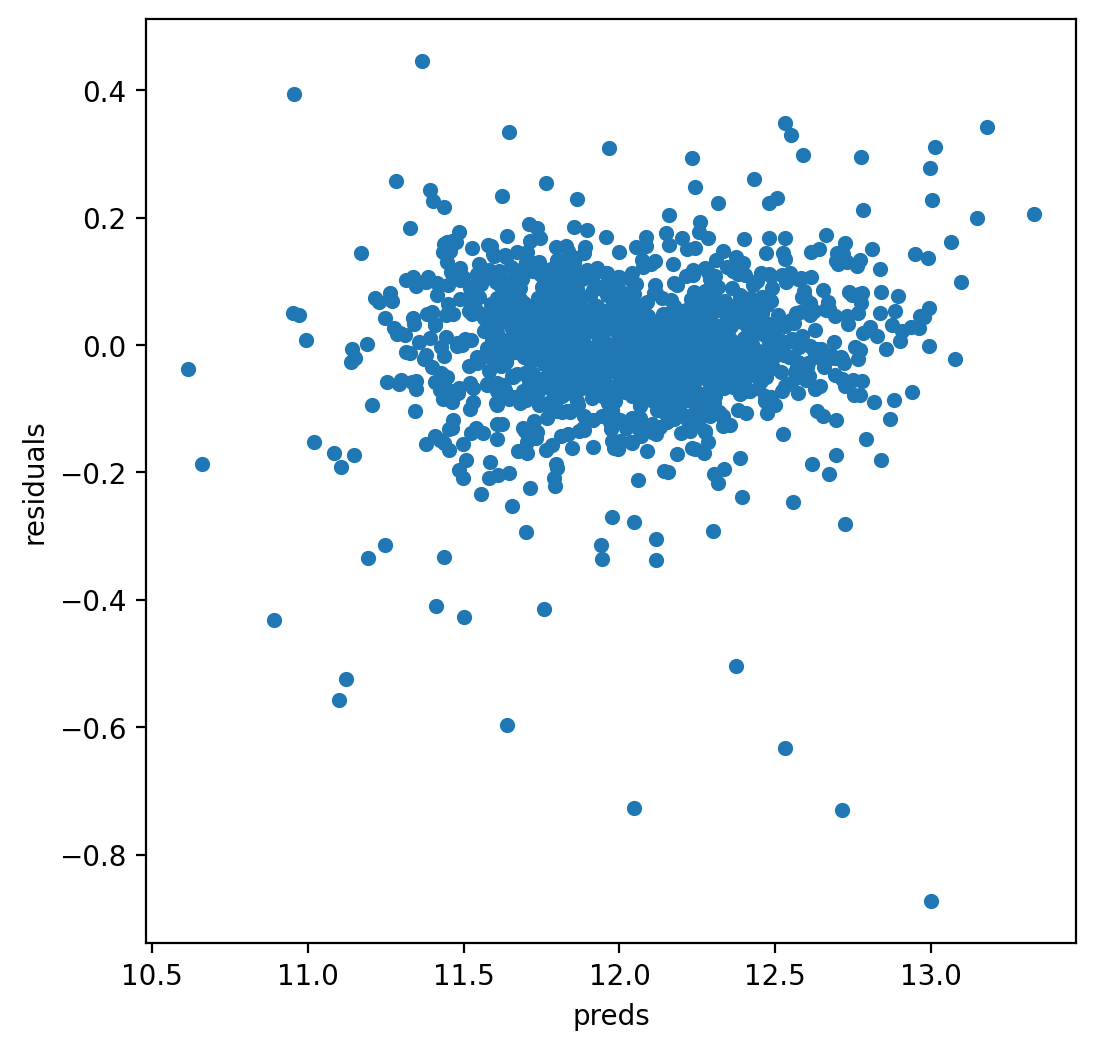

In [36]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [1]:
import xgboost as xgb

In [31]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<Axes: >

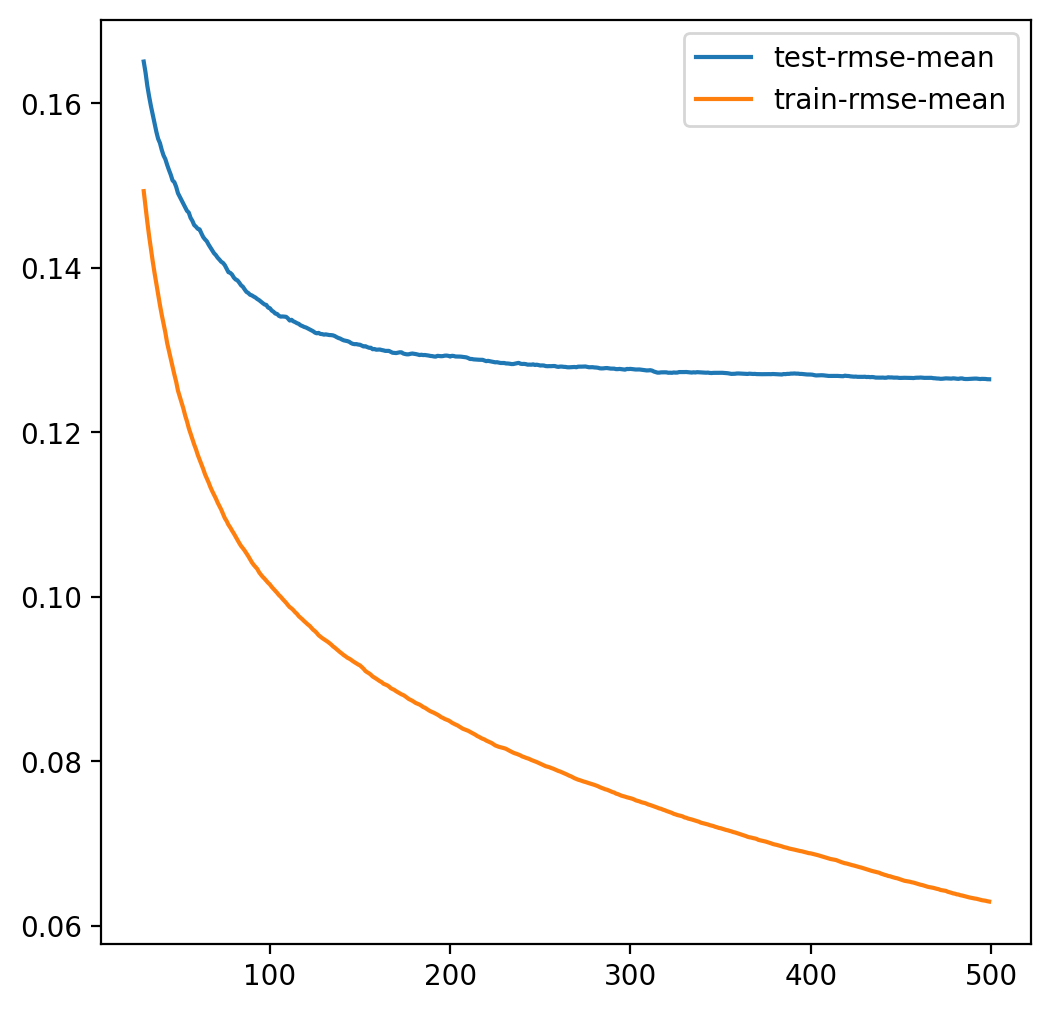

In [27]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<Axes: xlabel='xgb', ylabel='lasso'>

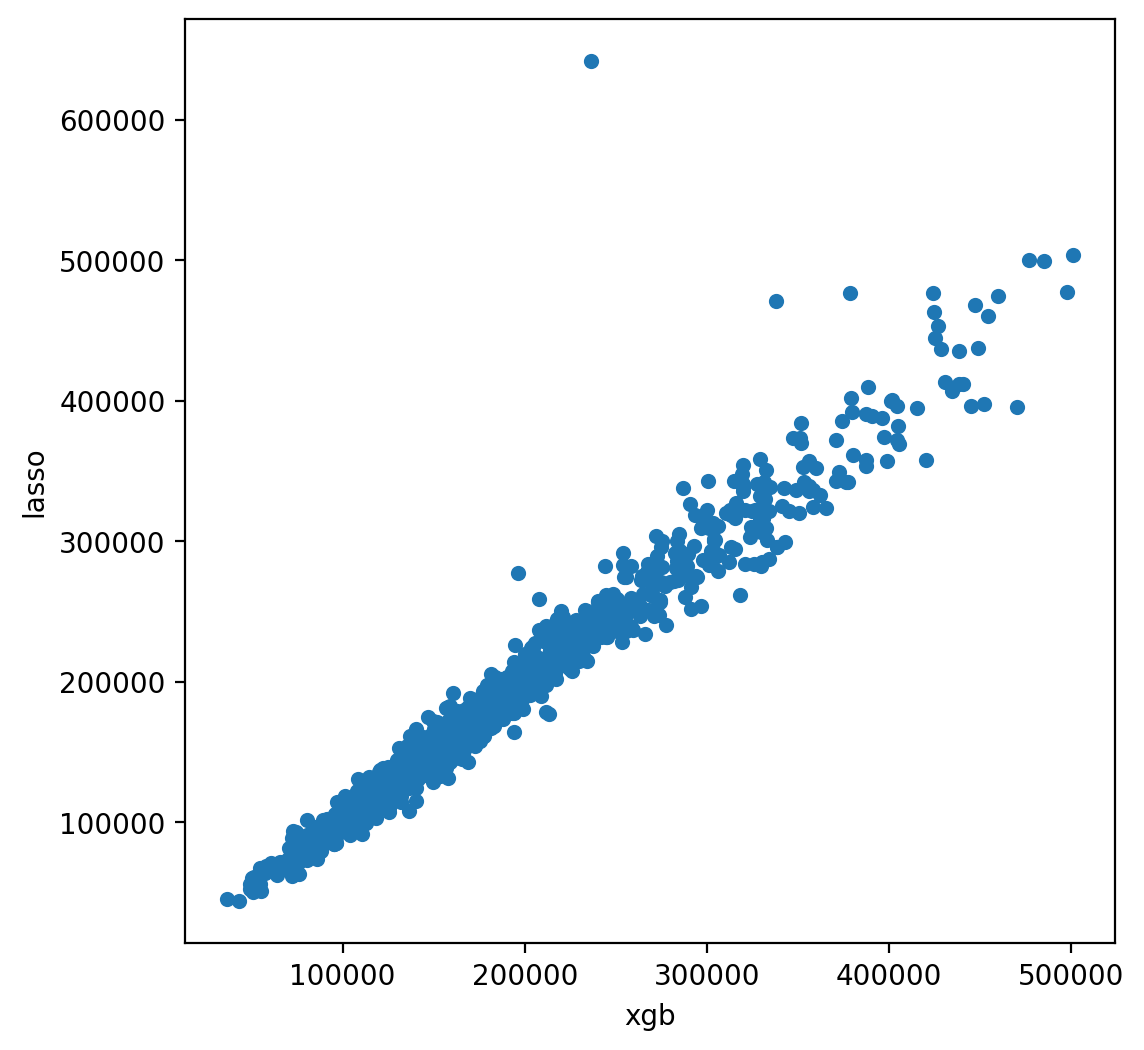

In [30]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [31]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [32]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

## Problem 3 (Nothing to turn in)

Run this simple example from scikit learn, and understand what each command is doing: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

## Problem 4

Use the data generation used in the LASSO notebook where we first introduced Lasso, to generate data.

You can find that again here: https://colab.research.google.com/drive/1_NGlKLpXpcobUIlan5DY5nA-5aT39Hxc

**Part 1.** Manually implement forward selection. Report the order in which you add features.

**Part 2.** In this example, we know the true support size is 5. But what if we did not know this? Plot test error as a function of the size of the support. Use this to recover the true support size. Justify your answer.

**Part 3.** Use Lasso with a manually implemented Cross validation using the metric of your choice.
What is the value of the hyperparameter? (Manually implemented means that you can either
do it entirely on your own, or you can use GridSearchCV, but I’m asking you not to use
LassoCV, which you will use in the next problem).

**Part 4.** (Optional) Change the number of folds in your CV and repeat the previous step. How does the optimal
value of the hyperparameter change? Try to explain any trends that you find.

**Part 5.** (Optional) Read about and use LassoCV from sklearn.linear model. How does this compare with what
you did in the previous step? If they agree, then explain why they agree, and if they disagree
explain why. This will require you to make sure you understand what LassoCV is doing.

In [34]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
sns.set(style='ticks', palette='Set2')
%matplotlib inline

In [35]:
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

# Beta generated with k nonzeros
k = 5
coef = 10 * np.ones(n_features)

# Find 5 random coefficients to make non-zero
inds = np.arange(n_features)
np.random.shuffle(inds)

# Sparsify Coef
coef[inds[k:]] = 0

y = np.dot(X, coef)

# Add Noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:25], y[:25]
X_test, y_test = X[25:], y[25:]

## Part 1

In [36]:
def forward_selection(X_train, y_train):
    selected_features = []
    remaining_features = [i for i in range(200)] # Indices ranging from 0 to 199
    res = []

    for _ in range(5): # Only 5 features
        max_feature = None
        min_score = float('inf')

        for feature in remaining_features:
            training_features = selected_features + [feature]
            model = linear_model.LinearRegression()

            model.fit(X_train[:, training_features], y_train)
            pred = model.predict(X_test[:, training_features])

            score = np.sqrt(mean_squared_error(y_test, pred))

            if score < min_score:
                min_score = score
                max_feature = feature
        
        selected_features.append(max_feature)
        remaining_features.remove(max_feature)
        res.append(max_feature)

    return res

print("Features were added in the following order:", forward_selection(X_train, y_train))

Features were added in the following order: [18, 51, 78, 137, 87]


## Part 2

In [32]:
'''
If we did not know what the true support size was prior to forward selection, we could continue adding features
until features stopped significantly improving the model's accuracy. At this point, we could confidently say that
this represents the number of features.
'''

"\nIf we did not know what the true support size was prior to forward selection, we could continue adding features\nuntil features stopped significantly improving the model's accuracy. At this point, we could confidently say that\nthis represents the number of features.\n"

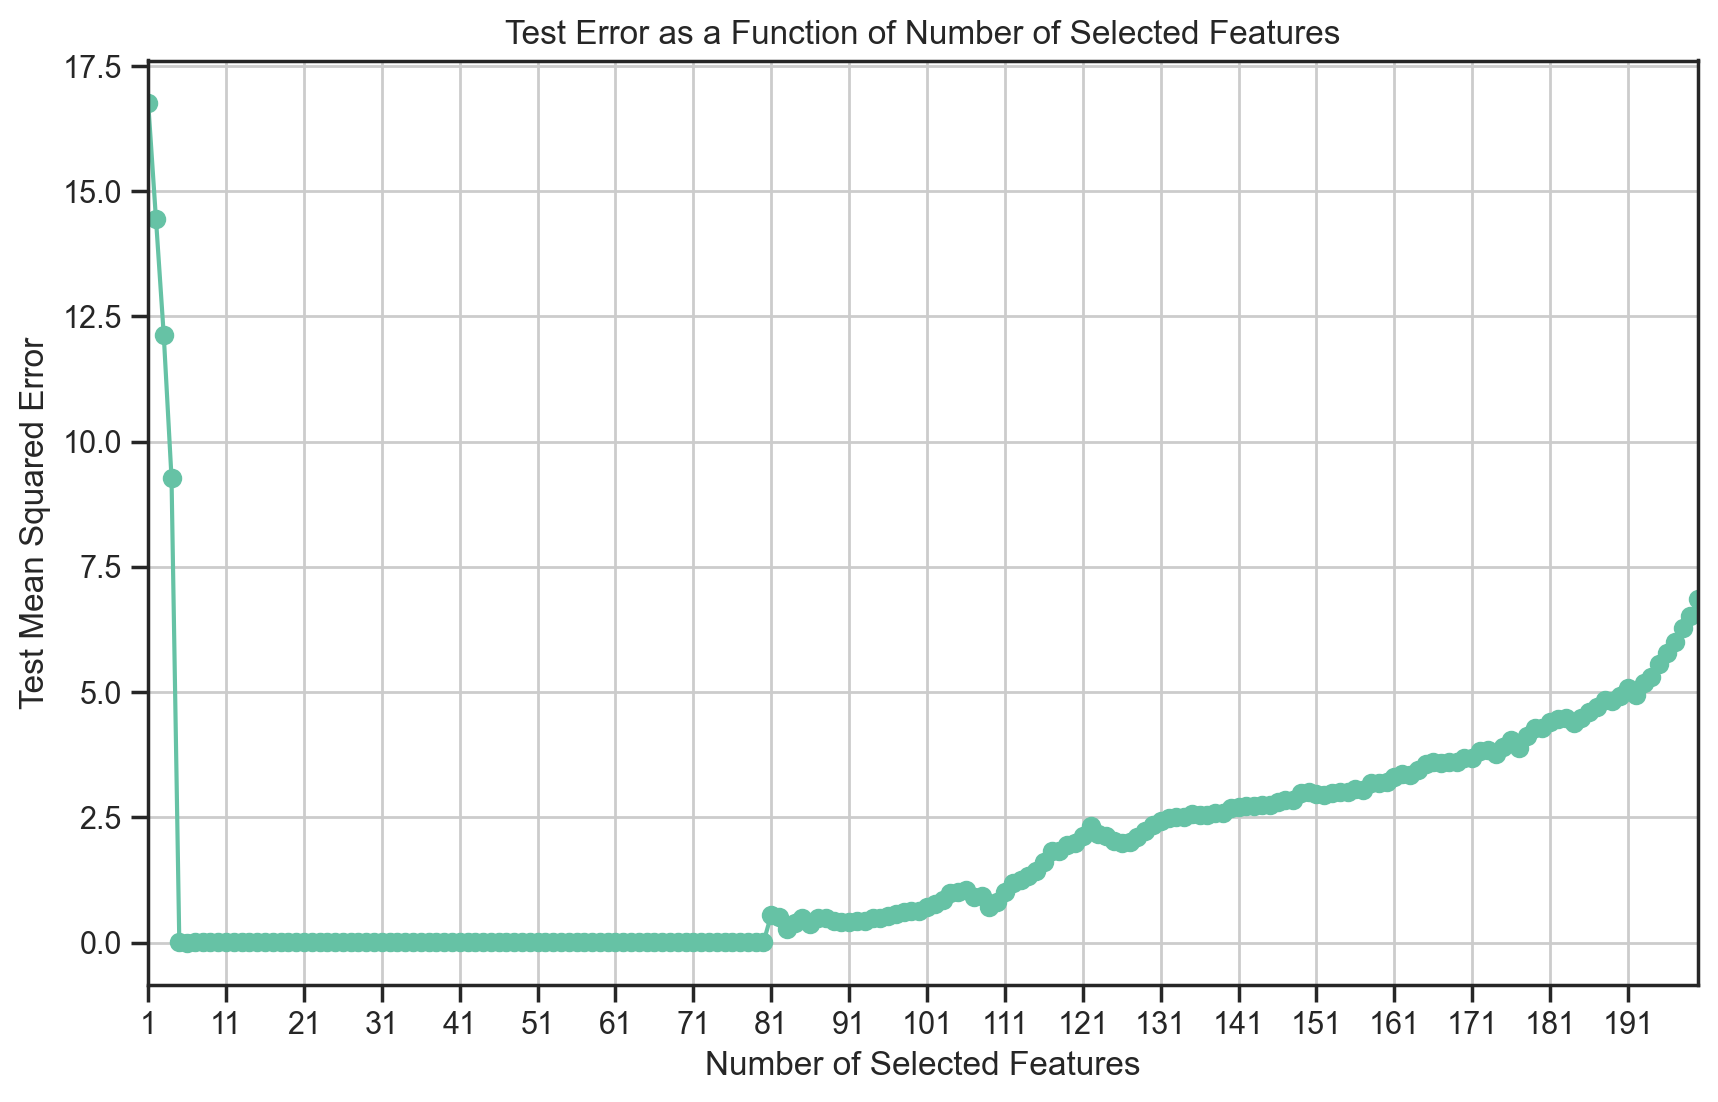

In [43]:
def modified_forward_selection(X_train, y_train):
    selected_features = []
    remaining_features = [i for i in range(200)] # Indices ranging from 0 to 199
    res1 = []
    res2 = []

    while remaining_features:
        max_feature = None
        min_score = float('inf')

        for feature in remaining_features:
            training_features = selected_features + [feature]
            model = linear_model.LinearRegression()

            model.fit(X_train[:, training_features], y_train)
            pred = model.predict(X_test[:, training_features])

            score = np.sqrt(mean_squared_error(y_test, pred))

            if score < min_score:
                min_score = score
                max_feature = feature
        
        selected_features.append(max_feature)
        remaining_features.remove(max_feature)
        res1.append(max_feature)
        res2.append(min_score)

    return [res1, res2]

feature, test_error = modified_forward_selection(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_error) + 1), test_error, marker='o')
plt.title('Test Error as a Function of Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Test Mean Squared Error')
plt.xticks(ticks=range(1, len(test_error) + 1, 10))
plt.xlim(1, len(test_error))
plt.grid()
plt.show()

In [41]:
'''
As shown by the plot above, it appears that after 5 features were selected by forward selection, the
amount each feature contributes to a reduction in the RMSE significantly decreases. From this information, we
can deduce that the true support size is +/- 5.
'''

'\nAs shown by the plot above, it appears that after 5 features were selected by forward selection, the\namount each feature contributes to a reduction in the RMSE significantly decreases. From this information, we\ncan deduce that the true support size is +/- 5.\n'

## Part 3

In [40]:
alphas = np.logspace(-4, 0, 50)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

alpha_rmse = []

for alpha in alphas:
    rmse_folds = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_folds.append(rmse)

    avg_mse = np.mean(rmse_folds)
    alpha_rmse.append((alpha, avg_mse))

best_alpha, best_mse = min(alpha_rmse, key=lambda x: x[1])

print(f"Best alpha (λ): {best_alpha}")
print(f"Best cross-validated MSE: {best_mse}")

final_lasso = Lasso(alpha=best_alpha, random_state=42)
final_lasso.fit(X, y)

print("Final model coefficients:", final_lasso.coef_)



c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+00, tolerance: 3.663e+00
  model = cd_fast.enet_coordinate_descent(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.281e+00, tolerance: 3.057e+00
  model = cd_fast.enet_coordinate_descent(
c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e+00, tolerance: 2.923e+00
  model = cd_fast.enet_

Best alpha (λ): 0.0024420530945486497
Best cross-validated MSE: 0.006488677958659146
Final model coefficients: [ 0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          9.99712775  0.         -0.
  9.99752592 -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.          9.99657025  0.
 -0.         -0.         -0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.
  0.         -0.         -0.          9.99704338 -0.          0.
  0.         -0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.
  9.99678142 -0.         -0.         -0.    

## Problem 5 (Optional): Higher vs Lower K in K-Fold CV.

Using either Ridge regression (e.g., with the setting in the Ridge Regression colab notebook) or Lasso (e.g., the setting of the Lasso colab notebook, also linked to above), or with any other data sets you wish to construct, design and execute an experiment to investigate the claim when we do $k$-fold cross validation, as $k$ decreases, we have more bias but less variance.  Note that this is an open-ended exercise. It is asking you to use simulation and investigate what is going on with increasing or decreasing the number of folds in cross validation.


## Problem 6 (Optional) Elastic Net

There may be settings where we want to combine ideas from Ridge and Lasso. There is a model that does this, by adding an L1 penalty (as in Lasso) and also an L2 penalty (as in Ridge). Read about this in sklearn and in [ISL](https://www.statlearning.com/) (or anywhere else). Try to construct an example where ElasticNetCV does better than LassoCV. Explain how you came up with this.
